# Exploring Oxford Nanopore DRS sequencing and alignment errors: ERCC spike-ins

Code for exploring the error rates observed in spike-in data from the ONT DRS datasets published in the paper Native long-read RNA sequencing of the Arabidopsis thaliana transcriptome. For this we're focussing on the ONT DRS reads, aligned to the spike-in sequences with minimap2, generated from adding the ERCC spike-ins to each of the four biological replicates of WT col-0 tissue.

ONT DRS data are supposed to be about ~85-90% accurate now, but what exactly doesthis means. Does is mean that out of 100 sequenced bases, 85 will be correct? Does this include mismatched, insertions and deletions?

In [1]:
import os, sys, pysam, numpy, json, matplotlib, re
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Datasets
import os, re
bam_files = {"col0_rep1":{"bamfile":"201901_col0_2916.bam",
                          "path":"../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq"},
             "col0_rep2a":{"bamfile":"201903_col0_2917_exp2.bam",
                          "path":"../../datasets/2020180405_FAH59362_WT_Col0_2917"},
             "col0_rep2b":{"bamfile":"201901_col0_2917.bam",
                          "path":"../../datasets/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917"},
             "col0_rep3":{"bamfile":"201901_col0_2918.bam",
                          "path":"../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918"},
             "col0_rep4":{"bamfile":"201901_col0_2919.bam",
                          "path":"../../datasets/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919"},
             "col0_5padapter_rep1":{"bamfile":"201902_col0_2916_5adapter_exp2.bam",
                                    "path":"../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916"},
             "col0_5padapter_rep2":{"bamfile":"201902_col0_2918_5adapter.bam",
                                    "path":"../../datasets/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918"}}

bamfiles=[]
for keystr in bam_files.keys():
    fullpath = os.path.join(bam_files[keystr]["path"], "aligned_data/ERCC92/",
                            bam_files[keystr]["bamfile"])
    bamfiles.append(fullpath)

In [3]:
def getBestAlignments(bamfile):
    
    """Get the best alignment of each read - where best == longest"""
    
    best_alns={}
    rej_alns={}
    spikein_counts={}
    
    for readaln in bamfile.fetch():
        if not readaln.is_unmapped and readaln.seq is not None:
            if readaln.query_name not in best_alns.keys():
                best_alns[readaln.query_name] = readaln
            elif readaln.alen > best_alns[readaln.query_name].alen:
                best_alns[readaln.query_name] = readaln
            else:
                rej_alns[readaln.query_name] = readaln
            thisref = bamfile.get_reference_name(readaln.reference_id)
            try:
                spikein_counts[thisref]+=1
            except KeyError:
                spikein_counts[thisref]=1
            
    return(best_alns, rej_alns, spikein_counts)

In [4]:
# get the reads for our datasets
alignments={}
spikein_counts={}
for bamfile in bamfiles:
    thisbam = pysam.AlignmentFile(bamfile, "rb")
    alns = getBestAlignments(thisbam)
    filename = os.path.basename(bamfile)
    print("{}:\n\tBest Alignments:\t{:>4d}\n\tRejected Alignments:\t{:>4d}".format(filename,
                                                                                   len(alns[0].keys()),
                                                                                   len(alns[1].keys())))
    alignments[os.path.basename(bamfile)]=alns[0]
    for refname in alns[2]:
        try:
            spikein_counts[refname]+=alns[2][refname]
        except KeyError:
            spikein_counts[refname]=alns[2][refname]
print("\nDetected {} spike-ins with {} reads:\n".format(len(spikein_counts.keys()),
                                                        sum(spikein_counts.values())))
for refname in sorted(spikein_counts, key=spikein_counts.get, reverse=True):
      print("{}: {:>5d}".format(refname, spikein_counts[refname]))

201901_col0_2916.bam:
	Best Alignments:	6753
	Rejected Alignments:	   2
201903_col0_2917_exp2.bam:
	Best Alignments:	 556
	Rejected Alignments:	   0
201901_col0_2917.bam:
	Best Alignments:	 701
	Rejected Alignments:	   0
201901_col0_2918.bam:
	Best Alignments:	 907
	Rejected Alignments:	   0
201901_col0_2919.bam:
	Best Alignments:	 525
	Rejected Alignments:	   0
201902_col0_2916_5adapter_exp2.bam:
	Best Alignments:	7004
	Rejected Alignments:	   0
201902_col0_2918_5adapter.bam:
	Best Alignments:	11323
	Rejected Alignments:	   1

Detected 59 chromosomes with 27774 reads:

ERCC-00002:  8375
ERCC-00074:  7980
ERCC-00096:  3518
ERCC-00046:  1902
ERCC-00130:  1453
ERCC-00113:  1247
ERCC-00171:   629
ERCC-00004:   533
ERCC-00003:   455
ERCC-00043:   228
ERCC-00145:   208
ERCC-00009:   186
ERCC-00060:   150
ERCC-00042:   127
ERCC-00111:   125
ERCC-00022:    95
ERCC-00136:    86
ERCC-00108:    79
ERCC-00076:    66
ERCC-00112:    46
ERCC-00079:    30
ERCC-00162:    28
ERCC-00071:    24
ERCC-0002

In [5]:
def countBaseInstances(thisstr, updatedic):
    
    """ for a string count the a, t, g,& c's and update the dictionary"""

    bases = ["A","T","G","C"]
    thiscount = {"A":0,"T":0,"G":0,"C":0}
    for base in bases:
        updatedic[base]+=thisstr.count(base)
        thiscount[base]+=thisstr.count(base)
    
    # sanity check
    if numpy.array(list(thiscount.values())).sum()!=len(thisstr):
        print(thiscount)
        raise ValueError("bases counted from string {} do not match string length {}".format(thisstr, len(thisstr)))
    
    return(updatedic)

def parseCStag(cstag, readseq):
    
    """Pases and extracts the identity and substitution information storred in a bam alignmnents cs flag
    
    See https://github.com/lh3/minimap2"""
    
    r = re.compile(":[0-9]+|\*[a-z][a-z]|[=\+\-][A-Za-z]+")
    csarr = numpy.array(r.findall(cstag))
    cs_stats = {"identity":0,
                "insertion":0,
                "deletion":0,
                "substitution":0,
                "refbases":""
                }
    
    cs_bpstats = {"insertion":{"A":0, "T":0, "C":0, "G":0},
                  "deletion":{"A":0, "T":0, "C":0, "G":0},
                  "substitution":{"A":[], "T":[], "C":[], "G":[]},
                  "identity":{"A":0, "T":0, "C":0, "G":0}}
    
    pos_in_read = 0
    for block in csarr:
        if block.startswith(":"):
            ilen = int(block.split(":")[1])
            cs_stats["identity"]+=ilen
            bases = readseq[pos_in_read:pos_in_read+ilen]
            pos_in_read+=ilen
            cs_stats["refbases"] = "{}{}".format(cs_stats["refbases"], bases)
            cs_bpstats["identity"] = countBaseInstances(bases, cs_bpstats["identity"])
        elif block.startswith("*"):
            bases = block.split("*")[1].upper()
            if len(bases)==2:
                cs_stats["substitution"]+=1
                cs_bpstats["substitution"][bases[0]].append(bases[1])
                cs_stats["refbases"] = "{}{}".format(cs_stats["refbases"], bases[0])
                pos_in_read+=1
            else:
                print(block)
        elif block.startswith("+"):
            bases = block.split("+")[1].upper()
            cs_stats["insertion"]+=len(bases)
            cs_bpstats["insertion"] = countBaseInstances(bases, cs_bpstats["insertion"])
            pos_in_read+=len(bases)
        elif block.startswith("-"):
            bases = block.split("-")[1].upper()
            cs_stats["deletion"]+=len(bases)
            cs_bpstats["deletion"] = countBaseInstances(bases, cs_bpstats["deletion"])
            cs_stats["refbases"] = "{}{}".format(cs_stats["refbases"], bases)
        else:
            print(block)
    
    for key in cs_bpstats["substitution"].keys():
        cs_bpstats["substitution"][key] = numpy.array(cs_bpstats["substitution"][key])
        
    return(cs_stats, cs_bpstats)

def getGlobalAlignmentStats(reads):
    
    """Get a summary of the alignment stats for the reads based on the cs tags"""
    
    stats = {"matches":[],
             "insertion":[],
             "deletion":[],
             "skip":[],
             "softclip":[],
             "hardclip":[],
             "padding":[],
             "seqmatch":[],
             "seqmismatch":[],
             "back":[],
             "EditDist":[],
             "nbases":[],
             "nalignedbases":[]
            }
    
    stats["refbases"]={"A":0, "T":0, "C":0, "G":0}
    stats["identity"]=[]
    stats["substitution"]=[]
    stats["bp_stats"]={"insertion":{"A":0, "T":0, "C":0, "G":0},
                       "deletion":{"A":0, "T":0, "C":0, "G":0},
                       "substitution":{"A":[], "T":[], "C":[], "G":[]},
                       "identity":{"A":0, "T":0, "C":0, "G":0}}
    
    for read in reads:
        try:
            # get cs tag info
            try:
                cs_stats, bp_stats = parseCStag(read.get_tag('cs'), read.seq)
            except:
                print(read)
                print(read.seq)
                raise
            
            # basic info
            stats["nbases"].append(read.query_length)
            stats["nalignedbases"].append(read.query_alignment_length)

            # sam cigar information
            read_cigar_stats = read.get_cigar_stats()[0]
            stats["matches"].append(read_cigar_stats[0])
            stats["insertion"].append(read_cigar_stats[1])
            stats["deletion"].append(read_cigar_stats[2])
            stats["skip"].append(read_cigar_stats[3])
            stats["softclip"].append(read_cigar_stats[4])
            stats["hardclip"].append(read_cigar_stats[5])
            stats["padding"].append(read_cigar_stats[6])
            stats["seqmatch"].append(read_cigar_stats[7])
            stats["seqmismatch"].append(read_cigar_stats[8])
            stats["back"].append(read_cigar_stats[9])
            stats["EditDist"].append(read_cigar_stats[10])

            # sanity checks:
            if cs_stats["insertion"]!=read_cigar_stats[1] or cs_stats["deletion"]!=read_cigar_stats[2] or (cs_stats["identity"]+cs_stats["substitution"])!=read_cigar_stats[0]:
                print(read.query_name)
                print("cs stats\n", cs_stats)
                print("cigar stats\n", read_cigar_stats)
                raise ValueError("cs flag information does not tally with sam cigar string information")
            else:
                stats["refbases"] = countBaseInstances(cs_stats["refbases"], stats["refbases"])
                stats["identity"].append(cs_stats["identity"])
                stats["substitution"].append(cs_stats["substitution"])
                for key in bp_stats.keys():
                    for base in bp_stats[key]:
                        if key=="substitution":
                            stats["bp_stats"][key][base] = numpy.append(stats["bp_stats"][key][base],bp_stats[key][base])
                        else:
                            stats["bp_stats"][key][base]+=bp_stats[key][base]
        except KeyError:
            raise

    for key in stats.keys():
        if key!="bp_stats" and key!="refbases":
            stats[key] = numpy.array(stats[key])
    
    return(stats)

In [6]:
# get the stats for our datasets
stats={}
for bamfile in alignments.keys():
    thisstats = getGlobalAlignmentStats(alignments[bamfile].values())
    stats[bamfile] = thisstats

In [7]:
def getCS(datadic):
    
    """Get the combined stats accross all datasets"""
    
    def getICS(datadic, statkey, datasets):
        retarr=None
        for dataset in datasets:
            if retarr is None:
                retarr = datadic[dataset][statkey]
            else:
                retarr = numpy.append(retarr, datadic[dataset][statkey])
        return(retarr)
    
    datasets = sorted(list(datadic.keys()))
    ret_stats = {}
    refbases = None
    bpstats = None
    for statkey in datadic[datasets[0]].keys():
        if statkey=="refbases":
            for dataset in datasets:
                if refbases is None:
                    refbases = datadic[dataset]["refbases"]
                else:
                    for base in refbases.keys():
                        refbases[base] = refbases[base]+datadic[dataset]["refbases"][base]
        elif statkey=="bp_stats":
            for dataset in datasets:
                if bpstats is None:
                    bpstats = datadic[dataset]["bp_stats"]
                else:
                    for akey in bpstats.keys():
                        if akey == "substitution":
                            for base in bpstats["substitution"].keys():
                                bpstats["substitution"][base] = numpy.append(bpstats["substitution"][base],
                                                                             datadic[dataset]["bp_stats"]["substitution"][base])
                        else:
                            for base in bpstats[akey].keys():
                                bpstats[akey][base] = bpstats[akey][base] + datadic[dataset]["bp_stats"][akey][base]
        else:
            ret_stats[statkey] = getICS(datadic, statkey, datasets)
    
    ret_stats["refbases"]=refbases
    ret_stats["bp_stats"]=bpstats
    return(ret_stats)

In [8]:
aln_stats = getCS(stats)

# Plotting some of the global alignment accuracy distributions

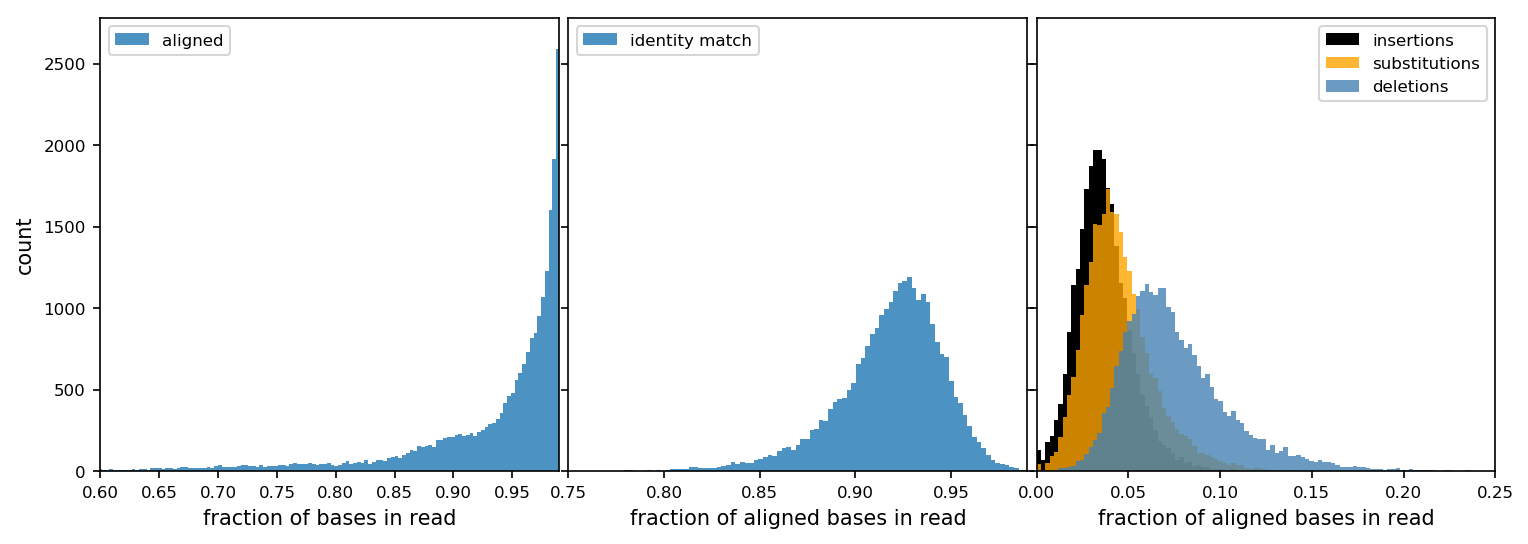

In [17]:
# Some plots.
labsize=8
bins=300

fig = plt.figure(figsize=(12,4), dpi=150)
fig.subplots_adjust(wspace=0.02)
ax1=plt.subplot(131)
ax1.tick_params(axis='both', which='major', labelsize=labsize)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%i'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
x = plt.hist(aln_stats["nalignedbases"]/aln_stats["nbases"], bins=bins, alpha=0.8, label="aligned")
plt.xlim((0.6,0.99))
plt.xlabel("fraction of bases in read")
plt.legend(loc=2, fontsize=labsize)
plt.ylabel("count")
ax2=plt.subplot(132, sharey=ax1)
ax2.tick_params(axis='x', which='major', labelsize=labsize)
ax2.tick_params(axis='y', which='both', left=True, right=True, labelleft=False)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
y = plt.hist(aln_stats["identity"]/aln_stats["nalignedbases"], bins=bins, alpha=0.8,
             label="identity match")
plt.xlim((0.75,0.99))
plt.xlabel("fraction of aligned bases in read")
plt.legend(loc=2, fontsize=labsize)
#plt.ylabel("count")
ax3=plt.subplot(133, sharey=ax1)
ax3.tick_params(axis='x', which='major', labelsize=labsize)
ax3.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
x = plt.hist(aln_stats["insertion"]/aln_stats["nalignedbases"], bins=bins, label="insertions", color='black')
y = plt.hist(aln_stats["substitution"]/aln_stats["nalignedbases"], bins=x[1], alpha=0.8, label="substitutions", color='orange')
z = plt.hist(aln_stats["deletion"]/aln_stats["nalignedbases"], bins=x[1], alpha=0.8, label="deletions", color='steelblue')
plt.xlim((0.0,0.25))
plt.xlabel("fraction of aligned bases in read")
plt.legend(loc=1, fontsize=labsize)
plt.xlabel("fraction of aligned bases in read")

plt.savefig("../figures/Figure_02.png", dpi=300, format="png")
plt.savefig("../figures/Figure_02.svg", dpi=300, format="svg")

In [28]:
# get a few interesting basic numbers such as the number of bases & the number of errors
print("Number of sequenced bases: {:>15d}".format(aln_stats["nbases"].sum()))
print("Number of aligned bases:   {:>15d}".format(aln_stats["nalignedbases"].sum()))
print("Number of errors bases:    {:>15d}".format(aln_stats["nalignedbases"].sum()-aln_stats["identity"].sum()))

Number of sequenced bases:        18660337
Number of aligned bases:          17544535
Number of errors bases:            1485779


In [29]:
# So lets actually get a number for the accuracy of our data....
mean_alnfrac = (aln_stats["nalignedbases"]/aln_stats["nbases"]).mean()
stddev_alnfrac = (aln_stats["nalignedbases"]/aln_stats["nbases"]).std()
print("Mean alignment fraction: {:.2f} +{:.4f} -{:.4f}".format(mean_alnfrac*100,
                                                               100*2*stddev_alnfrac,
                                                               100*2*stddev_alnfrac))
mean_identity = (aln_stats["identity"]/aln_stats["nalignedbases"]).mean()
stddev_identity = (aln_stats["identity"]/aln_stats["nalignedbases"]).std()
print("Mean identity: {:.2f} +{:.4f} -{:.4f}".format(mean_identity*100,
                                                     100*2*stddev_identity,
                                                     100*2*stddev_identity))
mean_insertion = (aln_stats["insertion"]/aln_stats["nalignedbases"]).mean()
stddev_insertion = (aln_stats["insertion"]/aln_stats["nalignedbases"]).std()
print("Mean insertions: {:.2f} +{:.4f} -{:.4f}".format(mean_insertion*100,
                                                       100*2*stddev_insertion,
                                                       100*2*stddev_insertion))
mean_deletion = (aln_stats["deletion"]/aln_stats["nalignedbases"]).mean()
stddev_deletion = (aln_stats["deletion"]/aln_stats["nalignedbases"]).std()
print("Mean deletion: {:.2f} +{:.4f} -{:.4f}".format(mean_deletion*100,
                                                     100*2*stddev_deletion,
                                                     100*2*stddev_deletion))
mean_substitution = (aln_stats["substitution"]/aln_stats["nalignedbases"]).mean()
stddev_substitution = (aln_stats["substitution"]/aln_stats["nalignedbases"]).std()
print("Mean substitution: {:.2f} +{:.4f} -{:.4f}".format(mean_substitution*100,
                                                         100*2*stddev_substitution,
                                                         100*2*stddev_substitution))

Mean alignment fraction: 93.63 +18.3910 -18.3910
Mean identity: 91.84 +5.7799 -5.7799
Mean insertions: 3.66 +3.4215 -3.4215
Mean deletion: 7.61 +5.9973 -5.9973
Mean substitution: 4.50 +3.7651 -3.7651


# Enrichment of error types by base

Now lets look to see if the base distributions for each error category are random or match the sequence distributions We'l start by looking at the frations of insertions, substitutions and deletions by base (See http://onlinestatbook.com/2/estimation/proportion_ci.html).

In [11]:
print("Fractions of each base in the reference sequence underlying each read:")
proportions={"refbases":{},
             "bp_stats":{}}

for base in aln_stats["refbases"]:
    proportion = aln_stats["refbases"][base]/sum(aln_stats["refbases"].values())
    SE = numpy.sqrt((proportion*(1-proportion))/sum(aln_stats["refbases"].values()))
    CI = (1.96*SE) + (0.5/sum(aln_stats["refbases"].values()))
    proportions["refbases"][base] = {"proportion": proportion, "SE": SE, "95CI": CI}
    print("{}: {:.2f} +/-{:.2f} (95% CI)".format(base, proportion*100, CI*100))

for key in aln_stats["bp_stats"]:
    proportions["bp_stats"][key] = {}
    if key!="substitution":
        print("{} fractions relative to all {}s by (reference) base:".format(key, key))
        for base in aln_stats["bp_stats"][key].keys():
            proportion = aln_stats["bp_stats"][key][base]/sum(aln_stats["bp_stats"][key].values())
            SE = numpy.sqrt((proportion*(1-proportion))/sum(aln_stats["bp_stats"][key].values()))
            CI = (1.96*SE) + (0.5/sum(aln_stats["bp_stats"][key].values()))
            proportions["bp_stats"][key][base] = {"proportion": proportion, "SE": SE, "95CI": CI}
            print("{}: {:.2f} +/-{:.2f} (95% CI)".format(base, proportion*100, CI*100))
            
print("Substitution fractions relative to all substitutions by reference base:")
for base in aln_stats["bp_stats"]["substitution"].keys():
    proportion = len(aln_stats["bp_stats"]["substitution"][base])/aln_stats["substitution"].sum()
    SE = numpy.sqrt((proportion*(1-proportion))/aln_stats["substitution"].sum())
    CI = (1.96*SE) + (0.5/aln_stats["substitution"].sum())
    proportions["bp_stats"]["substitution"][base] = {"proportion": proportion, "SE": SE, "95CI": CI, "breakdown":{}}
    print("{}({:.2f} +/-{:.2f} 95% CI):".format(base, proportion*100, CI*100))
    baseto_unique, baseto_counts = numpy.unique(aln_stats["bp_stats"]["substitution"][base], return_counts=True)
    baseto_dict = dict(zip(baseto_unique, baseto_counts))
    proportions["bp_stats"]["substitution"][base]["breakdown"] = {}
    print("\tSubstitution fractions relative to all substitutions of reference base {}, by target base:".format(base))
    for baseto in baseto_dict:
        proportion = baseto_dict[baseto]/baseto_counts.sum()
        SE = numpy.sqrt((proportion*(1-proportion))/baseto_counts.sum())
        CI = (1.96*SE) + (0.5/baseto_counts.sum())
        proportions["bp_stats"]["substitution"][base]["breakdown"][baseto] = {"proportion": proportion, "SE": SE, "95CI": CI}
        print("\t{}: {:.2f} +/-{:.2f} (95% CI)".format(baseto, proportion*100, CI*100))

Fractions of each base in the reference sequence underlying each read:
A: 27.16 +/-0.02 (95% CI)
T: 26.80 +/-0.02 (95% CI)
C: 23.19 +/-0.02 (95% CI)
G: 22.85 +/-0.02 (95% CI)
insertion fractions relative to all insertions by (reference) base:
A: 30.91 +/-0.11 (95% CI)
T: 31.85 +/-0.11 (95% CI)
C: 21.99 +/-0.10 (95% CI)
G: 15.26 +/-0.09 (95% CI)
deletion fractions relative to all deletions by (reference) base:
A: 28.68 +/-0.08 (95% CI)
T: 30.63 +/-0.08 (95% CI)
C: 25.45 +/-0.08 (95% CI)
G: 15.24 +/-0.06 (95% CI)
identity fractions relative to all identitys by (reference) base:
A: 27.14 +/-0.02 (95% CI)
T: 26.24 +/-0.02 (95% CI)
C: 22.83 +/-0.02 (95% CI)
G: 23.79 +/-0.02 (95% CI)
Substitution fractions relative to all substitutions by reference base:
A(25.09 +/-0.09 95% CI):
	Substitution fractions relative to all substitutions of reference base A, by target base:
	C: 15.81 +/-0.16 (95% CI)
	G: 46.22 +/-0.22 (95% CI)
	T: 37.97 +/-0.21 (95% CI)
T(31.74 +/-0.10 95% CI):
	Substitution fract

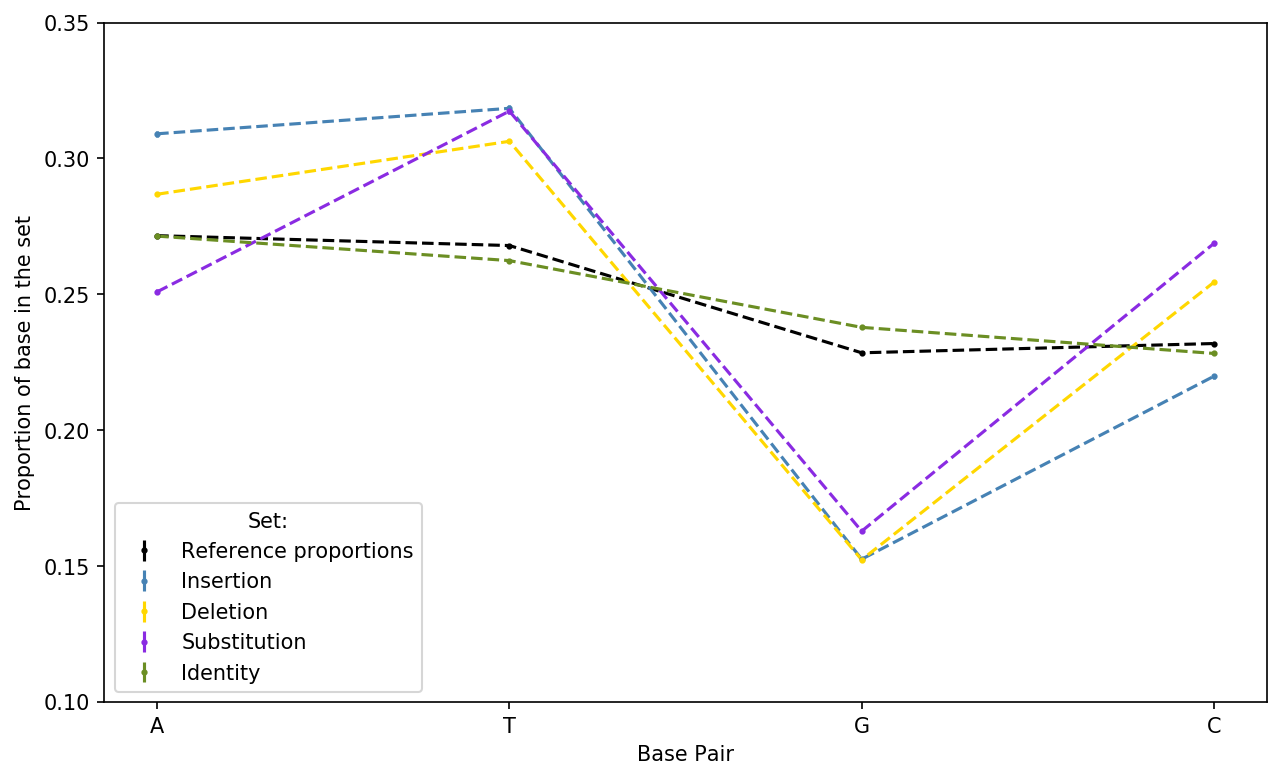

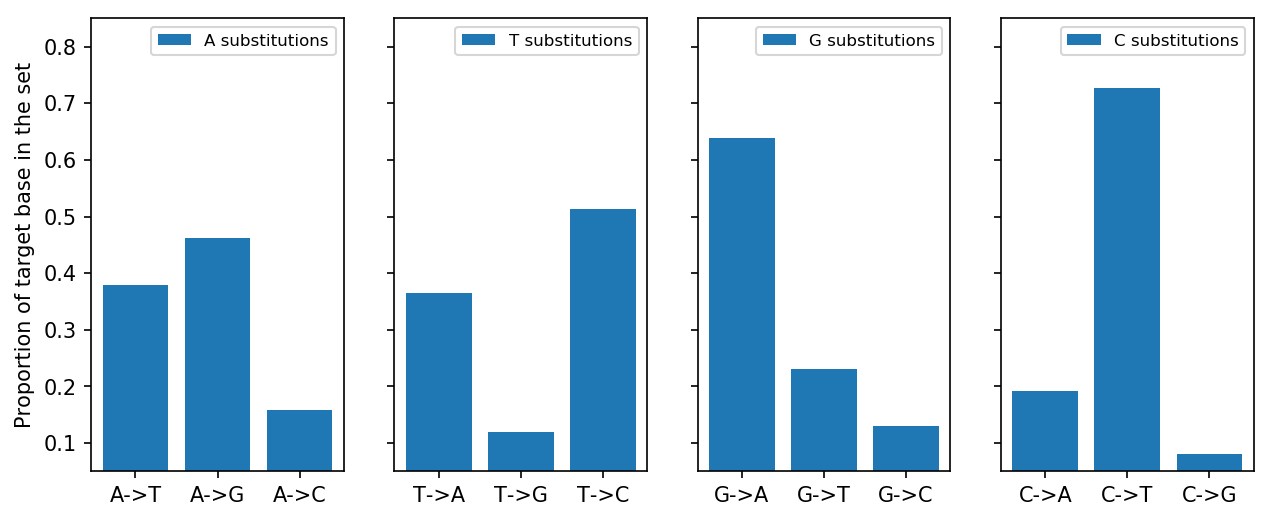

In [12]:
# Plot these proportions for each type of error. Here I'm going to use lines to highlight
# the different behaviours of the different errors...
bases = ["A","T","G","C"]
cols=['black', 'steelblue', 'gold', 'blueviolet', 'olivedrab']

fig = plt.figure(figsize=(10,6), dpi=150)
plotprops = []
ploterrors = []
for base in bases:
    plotprops.append(proportions['refbases'][base]["proportion"])
    ploterrors.append(proportions['refbases'][base]["95CI"])
refline = plt.plot(bases, plotprops, linestyle='--', zorder=1, color=cols[0])
refpoints = plt.errorbar(bases, plotprops, ploterrors, fmt="o", markersize=2,
                         label="Reference proportions", zorder=2, color=cols[0])

i=1
for key in proportions['bp_stats'].keys():
    plotprops = []
    ploterrors = []
    for base in bases:
        plotprops.append(proportions['bp_stats'][key][base]["proportion"])
        ploterrors.append(proportions['bp_stats'][key][base]["95CI"])
    thisline = plt.plot(bases, plotprops, linestyle='--', zorder=1, color=cols[i])
    thispoints = plt.errorbar(bases, plotprops, ploterrors, fmt="o", markersize=2,
                              label=key.capitalize(), zorder=2, color=cols[i])
    i+=1

plt.ylim((0.1,0.35))
plt.legend(title="Set:", loc=3, fontsize=10)
plt.xlabel("Base Pair")
plt.ylabel("Proportion of base in the set")
plt.savefig("../figures/Figure_03a.png", dpi=300, format="png")
plt.savefig("../figures/Figure_03a.svg", dpi=300, format="svg")

fig = plt.figure(figsize=(10,4), dpi=150)
x=141
p=None
for base in bases:
    if p is None:
        p = plt.subplot(x)
        ax = plt.gca()
        plt.ylabel("Proportion of target base in the set")
    else:
        ax = plt.subplot(x, sharey=p)
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plotbases = []
    plotprops = []
    ploterrors = []
    for baseto in bases:
        if baseto in proportions['bp_stats']["substitution"][base]["breakdown"].keys():
            plotbases.append("{}->{}".format(base, baseto))
            plotprops.append(proportions['bp_stats']["substitution"][base]["breakdown"][baseto]["proportion"])
            ploterrors.append(proportions['bp_stats']["substitution"][base]["breakdown"][baseto]["95CI"])
    plt.bar(plotbases, plotprops, label="{} substitutions".format(base.capitalize()))
    plt.ylim((0.05,0.85))
    x+=1
    plt.legend(loc=1, fontsize=8)

plt.savefig("../figures/Figure_03b.png", dpi=300, format="png")
plt.savefig("../figures/Figure_03b.svg", dpi=300, format="svg")

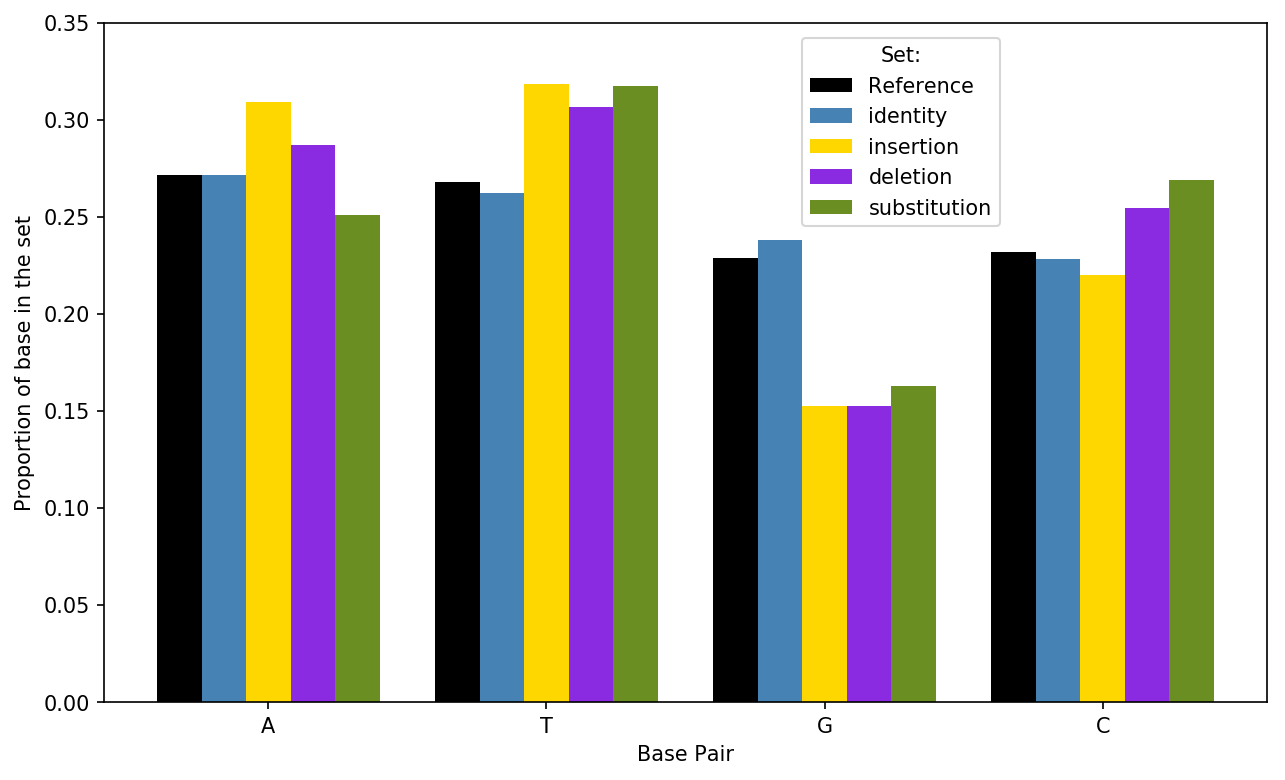

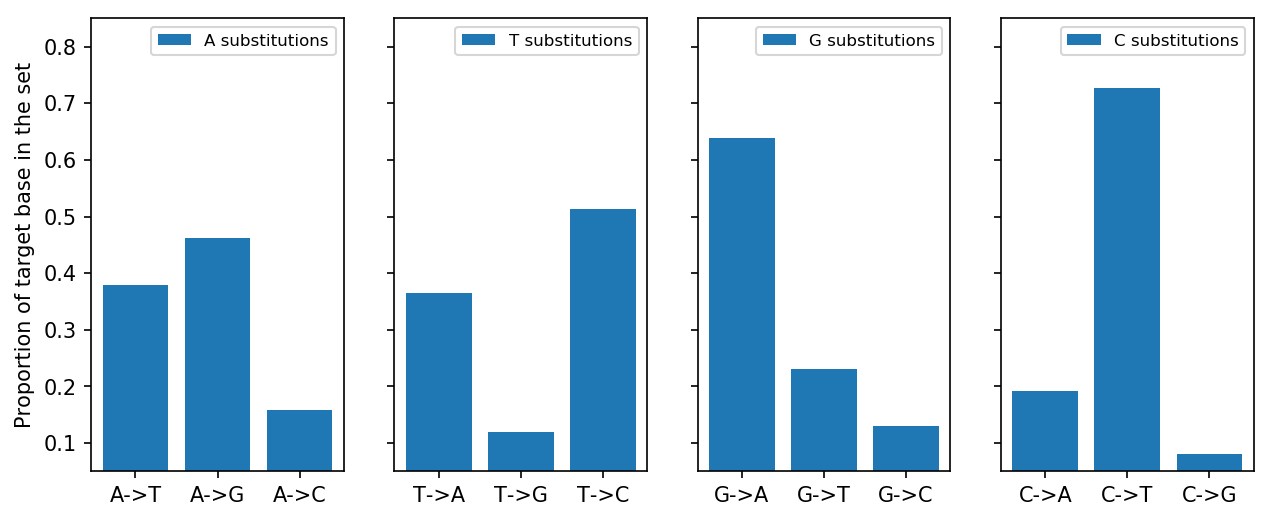

In [13]:
# Plot these proportions for each type of error. Here I'm going to using multiplebar plots because 
# Geoff thinks it will look better. It won't. ...
bases = ["A","T","G","C"]
plotprops = []
ploterrors = []
for base in bases:
    plotprops.append(proportions['refbases'][base]["proportion"])
    ploterrors.append(proportions['refbases'][base]["95CI"])

plotvals = [plotprops]
barlabels = ["Reference"]

barorder=['identity', 'insertion', 'deletion', 'substitution']
for key in barorder:
    plotprops = []
    ploterrors = []
    for base in bases:
        plotprops.append(proportions['bp_stats'][key][base]["proportion"])
        ploterrors.append(proportions['bp_stats'][key][base]["95CI"])
    plotvals.append(plotprops)
    barlabels.append(key)

fig = plt.figure(figsize=(10,6), dpi=150)
plt.set_cmap('jet')

def subcategorybar(X, vals, labels, colors, width=0.8):
    n = len(vals)
    _X = numpy.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge", label=labels[i], color=colors[i])   
    plt.xticks(_X, X)

cols=['black', 'steelblue', 'gold', 'blueviolet', 'olivedrab']
subcategorybar(bases, plotvals, barlabels, colors=cols)
plt.legend(title="Set:", loc=(0.6,0.7))
plt.ylim((0,0.35))
plt.xlabel("Base Pair")
plt.ylabel("Proportion of base in the set")

fig = plt.figure(figsize=(10,4), dpi=150)
x=141
p=None
for base in bases:
    if p is None:
        p = plt.subplot(x)
        ax = plt.gca()
        plt.ylabel("Proportion of target base in the set")
    else:
        ax = plt.subplot(x, sharey=p)
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plotbases = []
    plotprops = []
    ploterrors = []
    for baseto in bases:
        if baseto in proportions['bp_stats']["substitution"][base]["breakdown"].keys():
            plotbases.append("{}->{}".format(base, baseto))
            plotprops.append(proportions['bp_stats']["substitution"][base]["breakdown"][baseto]["proportion"])
            ploterrors.append(proportions['bp_stats']["substitution"][base]["breakdown"][baseto]["95CI"])
    plt.bar(plotbases, plotprops, label="{} substitutions".format(base.capitalize()))
    plt.ylim((0.05,0.85))
    x+=1
    plt.legend(loc=1, fontsize=8)

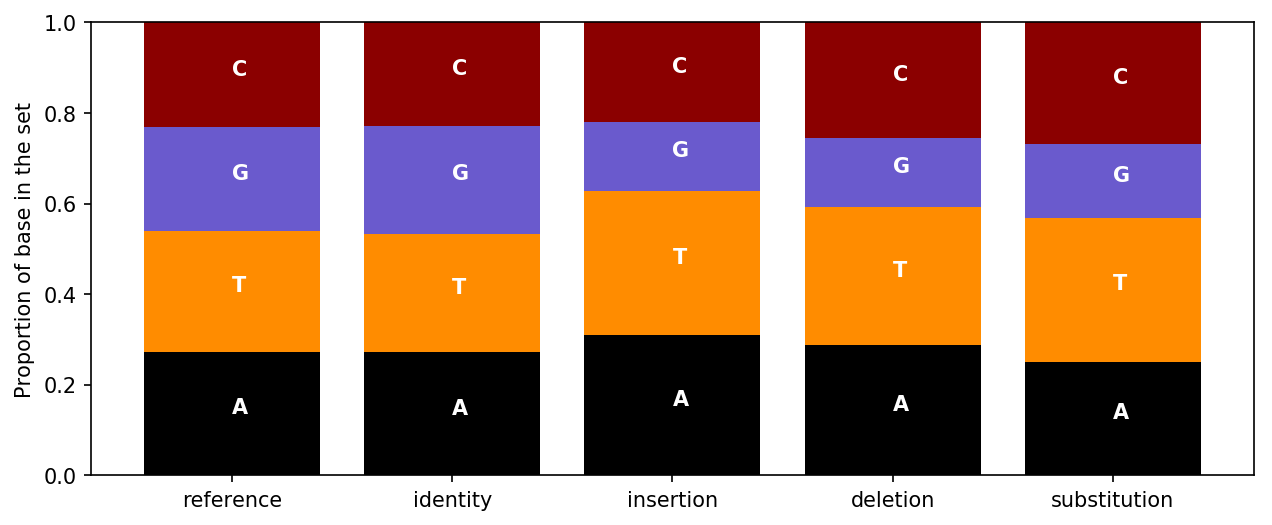

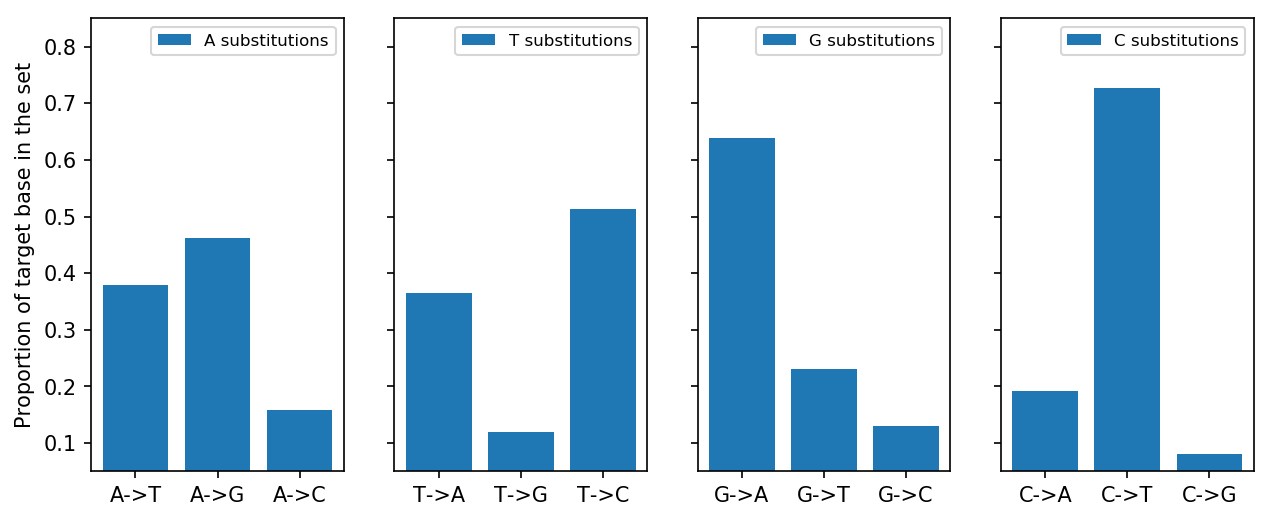

In [14]:
# Plot these proportions for each type of error. If we're going to use bar plots, stacked 
# bar plots by set with the relative base fractions might look better. It won't, but ...

bases = ["A","T","G","C"]

plotprops = []
ploterrors = []
for base in bases:
    plotprops.append(proportions['refbases'][base]["proportion"])
    ploterrors.append(proportions['refbases'][base]["95CI"])

plotvals = [plotprops]
pltorder = ['reference']

barorder=['identity', 'insertion', 'deletion', 'substitution']
for key in barorder:
    plotprops = []
    ploterrors = []
    for base in bases:
        plotprops.append(proportions['bp_stats'][key][base]["proportion"])
        ploterrors.append(proportions['bp_stats'][key][base]["95CI"])
    plotvals.append(plotprops)
    pltorder.append(key)

plotvals = numpy.array(plotvals)

fig = plt.figure(figsize=(10,4), dpi=150)
i=0
bottom=numpy.zeros(len(plotvals[:,0]))
cols=['black', 'darkorange', 'slateblue', 'darkred']
while i<len(bases):
    plt.bar(pltorder, plotvals[:,i], bottom=bottom, label=bases[i], color=cols[i])
    j=0
    while j<len(pltorder):
        plt.text(j, bottom[j]+(plotvals[j,i]/2), bases[i], color="white", fontweight='bold',)
        j+=1
    bottom=bottom+plotvals[:,i]
    i+=1
plt.ylim((0,1))
plt.ylabel("Proportion of base in the set")

fig = plt.figure(figsize=(10,4), dpi=150)
x=141
p=None
for base in bases:
    if p is None:
        p = plt.subplot(x)
        ax = plt.gca()
        plt.ylabel("Proportion of target base in the set")
    else:
        ax = plt.subplot(x, sharey=p)
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plotbases = []
    plotprops = []
    ploterrors = []
    for baseto in bases:
        if baseto in proportions['bp_stats']["substitution"][base]["breakdown"].keys():
            plotbases.append("{}->{}".format(base, baseto))
            plotprops.append(proportions['bp_stats']["substitution"][base]["breakdown"][baseto]["proportion"])
            ploterrors.append(proportions['bp_stats']["substitution"][base]["breakdown"][baseto]["95CI"])
    plt.bar(plotbases, plotprops, label="{} substitutions".format(base.capitalize()))
    plt.ylim((0.05,0.85))
    x+=1
    plt.legend(loc=1, fontsize=8)

In [15]:
# OK lets use the g-test to see if these are geninely significantly different proportions
from scipy.stats import chisquare
ref_props = []
for base in sorted(list(aln_stats["refbases"].keys())):
    ref_props.append(proportions['refbases'][base]["proportion"])
ref_props = numpy.array(ref_props)
    
for key in aln_stats["bp_stats"]:
    key_counts=[]
    for base in sorted(list(aln_stats["refbases"].keys())):
        if key!="substitution":
            key_counts.append(aln_stats["bp_stats"][key][base])
        else:
            key_counts.append(len(aln_stats["bp_stats"]["substitution"][base]))
    
    key_counts = numpy.array(key_counts)
    print("pvalue for {} proportions different from the reference: {:.2e}".format(key, chisquare(key_counts, ref_props*key_counts.sum()).pvalue))

pvalue for insertion proportions different from the reference: 0.00e+00
pvalue for deletion proportions different from the reference: 0.00e+00
pvalue for substitution proportions different from the reference: 0.00e+00
pvalue for identity proportions different from the reference: 0.00e+00
